In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [2]:
# 1. Define Transformations with Data Augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((48, 48)),  # Resize to 48x48 (FER2013 standard)
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

In [3]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((48, 48)),  # Resize to 48x48 (FER2013 standard)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

In [4]:
# ## Setting up Data Paths

train_data_path = r"C:\Users\Public\GUVI\code\project\emotion_detection\DATA\train"
test_data_path = r"C:\Users\Public\GUVI\code\project\emotion_detection\DATA\test"

In [5]:
import os

# Check if directories exist
print("Train Directory Exists:", os.path.isdir(train_data_path))
print("Test Directory Exists:", os.path.isdir(test_data_path))

print("Train Subdirectories:", os.listdir(train_data_path))
print("Test Subdirectories:", os.listdir(test_data_path))


Train Directory Exists: True
Test Directory Exists: True
Train Subdirectories: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test Subdirectories: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# 3. Define the CNN Model Architecture
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Additional layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Adjusted for the new input size
        self.fc2 = nn.Linear(256, len(train_dataset.classes))  # Number of classes in the dataset
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))  # Apply third convolution layer
        x = x.view(-1, 128 * 6 * 6)  # Flatten for the fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
# 4. Initialize Model, Loss Function, and Optimizer
model = EmotionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [10]:
# 5. Early Stopping Parameters
best_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping
counter = 0

In [11]:
# 6. Training the Model with Tracking Loss and Accuracy
train_losses = []
train_accuracies = []

In [12]:
epochs = 30  # Number of epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping on epoch {epoch+1}')
        break


Epoch [1/30], Loss: 1.6834, Accuracy: 0.3253
Epoch [2/30], Loss: 1.4613, Accuracy: 0.4367
Epoch [3/30], Loss: 1.3482, Accuracy: 0.4824
Epoch [4/30], Loss: 1.2877, Accuracy: 0.5112
Epoch [5/30], Loss: 1.2387, Accuracy: 0.5284
Epoch [6/30], Loss: 1.2039, Accuracy: 0.5455
Epoch [7/30], Loss: 1.1841, Accuracy: 0.5518
Epoch [8/30], Loss: 1.1596, Accuracy: 0.5629
Epoch [9/30], Loss: 1.1394, Accuracy: 0.5708
Epoch [10/30], Loss: 1.1212, Accuracy: 0.5789
Epoch [11/30], Loss: 1.1093, Accuracy: 0.5805
Epoch [12/30], Loss: 1.0926, Accuracy: 0.5879
Epoch [13/30], Loss: 1.0847, Accuracy: 0.5909
Epoch [14/30], Loss: 1.0786, Accuracy: 0.5944
Epoch [15/30], Loss: 1.0576, Accuracy: 0.6023
Epoch [16/30], Loss: 1.0537, Accuracy: 0.5994
Epoch [17/30], Loss: 1.0444, Accuracy: 0.6052
Epoch [18/30], Loss: 1.0355, Accuracy: 0.6071
Epoch [19/30], Loss: 1.0271, Accuracy: 0.6150
Epoch [20/30], Loss: 1.0190, Accuracy: 0.6158
Epoch [21/30], Loss: 1.0113, Accuracy: 0.6192
Epoch [22/30], Loss: 0.9995, Accuracy: 0.62

In [13]:
# 7. Plot Training Loss and Accuracy
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

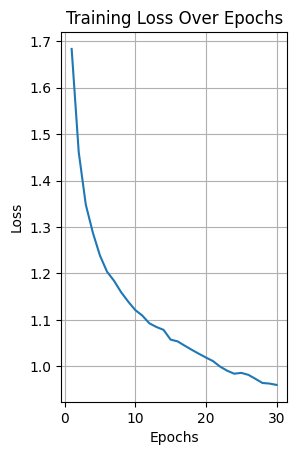

In [14]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)


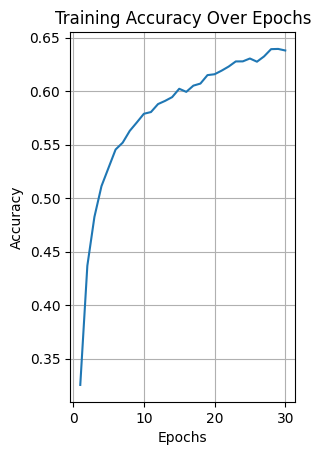

In [15]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.grid(True)


In [16]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [21]:
# 8. Evaluate the Model on Test Set and Plot Confusion Matrix
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No gradient calculation needed for inference
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

Accuracy: 0.6091
Precision: 0.6095
Recall: 0.6091
F1 Score: 0.6074


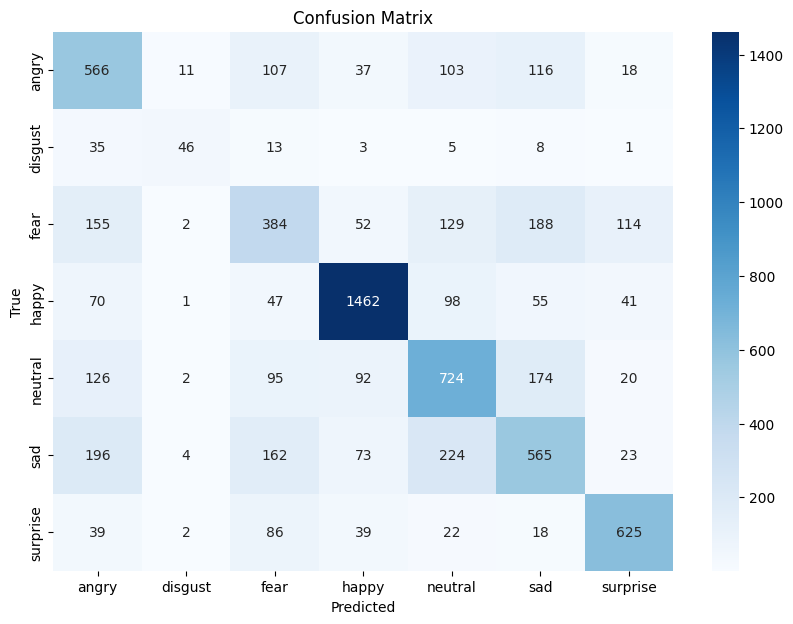

(0.609083310114238,
 np.float64(0.609467395358724),
 np.float64(0.609083310114238),
 np.float64(0.607402645075074))

In [22]:
# Call the evaluation function after training
evaluate_model(model, test_loader)

In [23]:
# 9. Save the Trained Model
torch.save(model.state_dict(), r"C:\Users\Public\GUVI\code\project\emotion_detection\emotion_cnn_model.pth")


In [24]:
# 10. Load the Model for Inference
model = EmotionCNN()
model.load_state_dict(torch.load(r"C:\Users\Public\GUVI\code\project\emotion_detection\emotion_cnn_model.pth"))
model.eval()  # Set to evaluation mode

C:\Users\MP KUMAR\AppData\Local\Temp\ipykernel_4084\3489147418.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\Public\GUVI\co

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)